In [1]:
import json
import tempfile

import pandas as pd
import seaborn as sns
import xarray as xr
from tqdm import tqdm

# from lausanne_greening_scenarios.invest import utils as invest_utils
from lausanne_greening_scenarios.scenarios import utils as scenarios_utils

# register tqdm with pandas to be able to use `progress_apply`
tqdm.pandas()

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
scenario_metrics_filepath = '../data/interim/scenario-metrics.csv'
scenario_lulc_filepath = '../data/interim/scenario-da.nc'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
ref_et_da_filepath = '../data/interim/invest/ref-et.nc'
t_da_filepath = '../data/processed/tair-ucm.nc'
calibrated_params_filepath = '../data/interim/invest/calibrated-params.json'

In [3]:
scenario_metrics_df = pd.read_csv(scenario_metrics_filepath)
scenario_metrics_df = scenario_metrics_df.groupby(['interaction', 'change_prop']).mean().drop('scenario_run', axis=1).reset_index()

In [4]:
scenario_lulc_da = xr.open_dataarray(scenario_lulc_filepath)
rio_meta = scenario_lulc_da.attrs.copy()
scenario_lulc_da = scenario_lulc_da.mean('scenario_run').round().astype(rio_meta['dtype'])
scenario_dims = scenario_lulc_da.coords.dims[:-2]
scenario_lulc_da.attrs = rio_meta

In [5]:
t_da = xr.open_dataarray(t_da_filepath)
hottest_day = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())['time'].dt.strftime('%Y-%m-%d').item()
# hottest_day = '2019-07-24'
t_ref = t_da.sel(time=hottest_day).min(dim=['x', 'y']).item()
uhi_max = t_da.sel(time=hottest_day).max(dim=['x', 'y']).item() - t_ref

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=hottest_day)
tmp_dir = tempfile.TemporaryDirectory()
# ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
#     ref_et_da, hottest_day, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))
ref_et_raster_filepath = '../data/interim/ref_eto_2019-07-24.tif'

In [6]:
with open(calibrated_params_filepath) as src:
    ucm_params = json.load(src)

In [7]:
sw = scenarios_utils.ScenarioWrapper(scenario_lulc_da, biophysical_table_filepath, ref_et_raster_filepath, t_ref, uhi_max, ucm_params)

In [8]:
scenario_metrics_df['T_avg'] = scenario_metrics_df.progress_apply(sw.compute_t_avg, axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

  9%|▉         | 2/22 [00:22<03:42, 11.12s/it]

 14%|█▎        | 3/22 [00:46<04:47, 15.15s/it]

 18%|█▊        | 4/22 [01:11<05:22, 17.90s/it]

 23%|██▎       | 5/22 [01:34<05:33, 19.63s/it]

 27%|██▋       | 6/22 [01:58<05:34, 20.93s/it]

 32%|███▏      | 7/22 [02:22<05:25, 21.69s/it]

 36%|███▋      | 8/22 [02:46<05:12, 22.33s/it]

 41%|████      | 9/22 [03:08<04:52, 22.48s/it]

 45%|████▌     | 10/22 [03:31<04:31, 22.60s/it]

 50%|█████     | 11/22 [03:56<04:14, 23.14s/it]

 55%|█████▍    | 12/22 [04:20<03:53, 23.37s/it]

 59%|█████▉    | 13/22 [04:42<03:28, 23.18s/it]

 64%|██████▎   | 14/22 [05:06<03:07, 23.43s/it]

 68%|██████▊   | 15/22 [05:30<02:44, 23.54s/it]

 73%|███████▎  | 16/22 [05:53<02:20, 23.49s/it]

 77%|███████▋  | 17/22 [06:17<01:57, 23.47s/it]

 82%|████████▏ | 18/22 [06:41<01:34, 23.72s/it]

 86%|████████▋ | 19/22 [07:05<01:11, 23.80s/it]

 91%|█████████ | 20/22 [07:29<00:47, 23.88s/it]

 95%|█████████▌| 21/22 [07:54<00:24, 24.04s/it]

100%|██████████| 22/22 [08:18<00:00, 24.18s/it]

100%|██████████| 22/22 [08:41<00:00, 23.70s/it]

In [9]:
scenario_metrics_df

,interaction,change_prop,area_mn,edge_density,shape_index_mn,proportion_of_landscape,T_avg
0,cluster,0.0,8.742936e+09,0.000763,1.206352,17.264191,28.308452
1,cluster,0.1,1.660159e+10,0.000773,1.259594,20.874333,28.294746
2,cluster,0.2,2.696286e+10,0.000900,1.445838,24.484475,28.275747
3,cluster,0.3,4.118657e+10,0.000939,1.457859,28.094617,28.249757
4,cluster,0.4,1.189780e+10,0.001323,1.185658,31.704759,28.238648
5,cluster,0.5,1.323251e+10,0.001625,1.266195,35.314901,28.212771
6,cluster,0.6,2.113441e+10,0.001812,1.327801,38.925043,28.185550
7,cluster,0.7,3.666153e+10,0.001883,1.311882,42.535185,28.161112
8,cluster,0.8,5.667844e+10,0.001839,1.284982,46.145327,28.135010
9,cluster,0.9,7.703151e+10,0.001678,1.273187,49.755468,28.105177


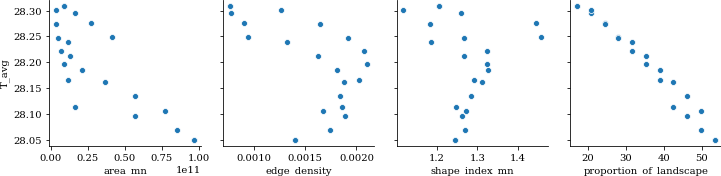

In [10]:
sns.pairplot(scenario_metrics_df, x_vars=scenario_metrics_df.columns[2:-1], y_vars=['T_avg'])